In [4]:
import numpy as np
import pandas as pd
import os

from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator as data_augment
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,Dropout,Flatten,Dense,GlobalAveragePooling2D,BatchNormalization,TimeDistributed,LSTM
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras import layers as layers
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.metrics import classification_report
from collections import Counter
import matplotlib.pyplot as plt
from keras.utils import to_categorical, plot_model

In [1]:
!pip install split-folders

## Splitting data

In [6]:
import splitfolders

data_d = "C:\\Users\\Hp\\Downloads\\Final Thesis\\drowsiness_split"
output_d = 'C:\\Users\\Hp\\Downloads\\Final Thesis\\drowsiness_split\\drowsiness_split'
splitfolders.ratio(data_d, output=output_d, seed=1942, ratio=(.8, .15, .05))

Copying files: 1159 files [00:05, 193.44 files/s]


In [7]:
train = "C:\\Users\\Hp\Downloads\\Final Thesis\\drowsiness_split\\drowsiness_split\\train"
test = "C:\\Users\\Hp\\Downloads\\Final Thesis\\drowsiness_split\\drowsiness_split\\test"
validation = "C:\\Users\\Hp\\Downloads\\Final Thesis\\drowsiness_split\\drowsiness_split\\val"

In [8]:
train_datagen = data_augment(rescale=1./255)
test_datagen = data_augment(rescale=1./255)
val_datagen = data_augment(rescale=1./255)

In [9]:
train_batches = train_datagen.flow_from_directory(
    train,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    shuffle=True
)
test_batches = test_datagen.flow_from_directory(
    test,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary' ,
    shuffle=True
)
val_batches = val_datagen.flow_from_directory(
    validation,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    shuffle=True
)

Found 927 images belonging to 2 classes.
Found 59 images belonging to 2 classes.
Found 173 images belonging to 2 classes.


In [10]:
train_class_indices = train_batches.class_indices
test_class_indices = test_batches.class_indices
val_class_indices = val_batches.class_indices

train_class_labels = train_batches.classes
test_class_labels = test_batches.classes
val_class_labels = val_batches.classes


train_class_counts = Counter(train_class_labels)
test_class_counts = Counter(test_class_labels)
val_class_counts = Counter(val_class_labels)

print("Class Names for train:\n", train_class_indices)
print("Class Counts for train:\n", train_class_counts)
print(end='\n')

print("Class Names for test:\n", test_class_indices)
print("Class Counts for test:\n", test_class_counts)
print(end='\n')

print("Class Names for validation :\n", val_class_indices)
print("Class Counts for validation:\n", val_class_counts)

Class Names for train:
 {'awake': 0, 'drowsy': 1}
Class Counts for train:
 Counter({0: 532, 1: 395})

Class Names for test:
 {'awake': 0, 'drowsy': 1}
Class Counts for test:
 Counter({0: 34, 1: 25})

Class Names for validation :
 {'awake': 0, 'drowsy': 1}
Class Counts for validation:
 Counter({0: 99, 1: 74})


Pixels of the first image after Normalization: 

[[[0.11764707 0.11764707 0.11764707]
  [0.13333334 0.13333334 0.13333334]
  [0.10980393 0.10980393 0.10980393]
  ...
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]]

 [[0.1137255  0.1137255  0.1137255 ]
  [0.1254902  0.1254902  0.1254902 ]
  [0.10588236 0.10588236 0.10588236]
  ...
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]]

 [[0.1137255  0.1137255  0.1137255 ]
  [0.1137255  0.1137255  0.1137255 ]
  [0.09803922 0.09803922 0.09803922]
  ...
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]]

 ...

 [[0.11764707 0.11764707 0.11764707]
  [0.11764707 0.11764707 0.11764707]
  [0.11764707 0.11764707 0.11764707]
  ...
  [0.11764707 0.11764707 0.11764707]
  [0.11764707 0.11764707 0.11764707]
  [0.11764707 0.11764707 0.11764707]]

 [[0.11764707 0.11764707 

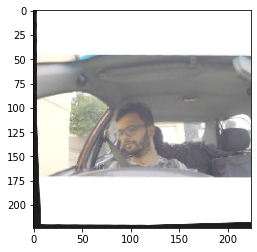

In [11]:
images, labels = next(train_batches)
print(f"Pixels of the first image after Normalization: \n\n{images[0]}") #print pixels of the first img
plt.imshow(images[0])
plt.show()

In [12]:
print(f"there are { images[0].ndim} Channels ")
print(f"image shape : {images[0].shape}")

there are 3 Channels 
image shape : (224, 224, 3)


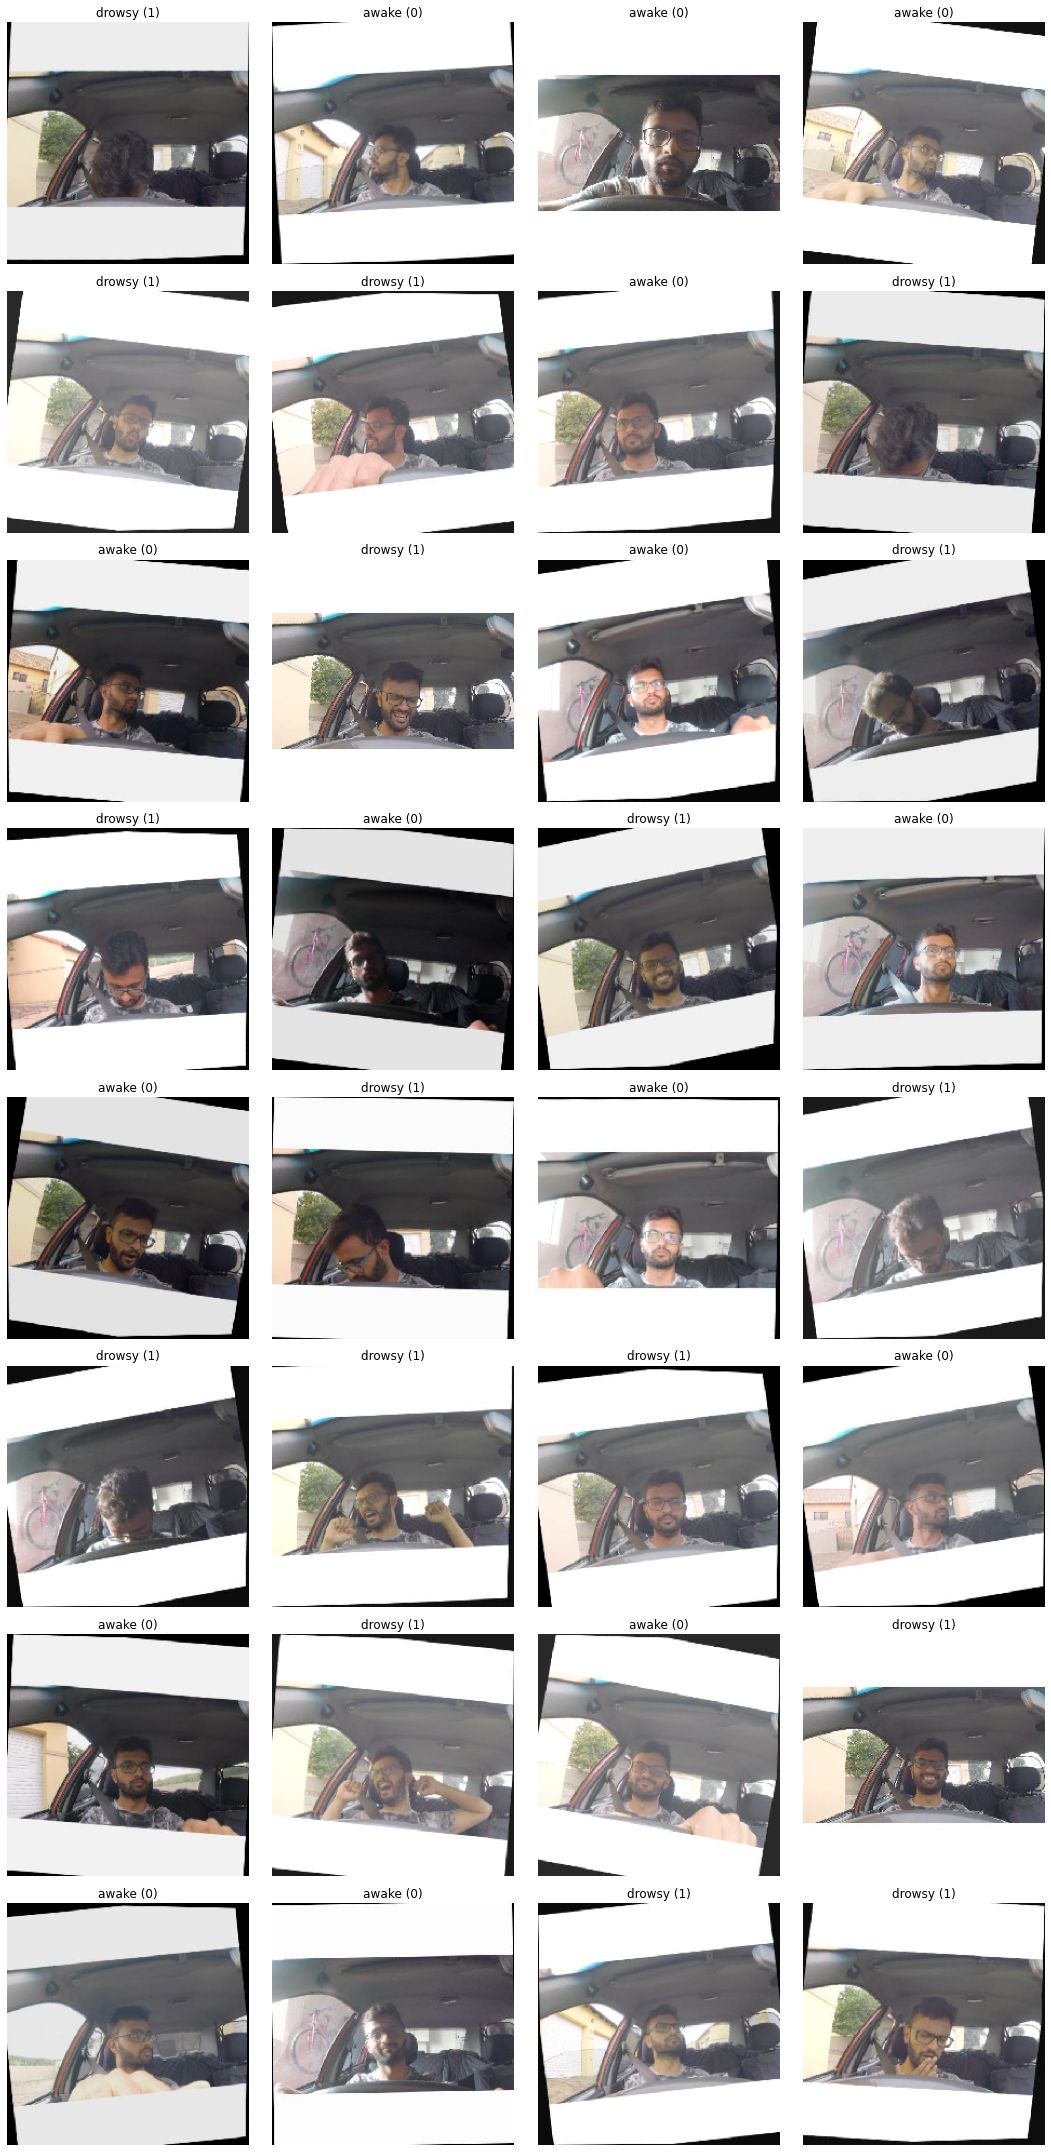

In [13]:
fig, axes = plt.subplots(8, 4, figsize=(15, 30))
class_indices = train_batches.class_indices

for i in range(8):
    images, labels = next(train_batches)
    for j in range(4):
        
        ax = axes[i, j]
        ax.imshow(images[j])
        ax.axis('off')
        label = int(labels[j])  
        label_name = list(class_indices.keys())[list(class_indices.values()).index(label)]
        ax.set_title(f'{label_name} ({label})')

plt.tight_layout()
plt.show()

## Defining model

In [14]:
model_base = keras.applications.ResNet50V2(
    weights='imagenet',
    include_top=False,
    input_shape = (224, 224, 3)
)
model_base.trainable=False

In [15]:
model_base.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

In [16]:
x = model_base.output
x = TimeDistributed(Flatten())(x)
x = LSTM(128, return_sequences=True)(x)
x = Dense(1024, activation = 'relu')(x)
x = Dense(512, activation = 'relu')(x)
x = Flatten()(x)
preds = Dense(2, activation='softmax')(x)
model = Model(inputs=model_base.input, outputs=preds)

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [18]:
model.compile(optimizer=Adam(0.0001),
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

## Model fitting

In [19]:
history = model.fit(train_batches, epochs = 10, validation_data = val_batches, batch_size=32)

Epoch 1/10
58/58 [==============================] - 42s 673ms/step - loss: 0.5977 - accuracy: 0.7012 - val_loss: 0.5220 - val_accuracy: 0.7514
Epoch 2/10
58/58 [==============================] - 36s 628ms/step - loss: 0.3705 - accuracy: 0.8403 - val_loss: 0.5096 - val_accuracy: 0.7341
Epoch 3/10
58/58 [==============================] - 40s 699ms/step - loss: 0.1881 - accuracy: 0.9407 - val_loss: 0.4138 - val_accuracy: 0.8324
Epoch 4/10
58/58 [==============================] - 38s 662ms/step - loss: 0.0695 - accuracy: 0.9849 - val_loss: 0.5458 - val_accuracy: 0.8150
Epoch 5/10
58/58 [==============================] - 40s 695ms/step - loss: 0.0281 - accuracy: 0.9935 - val_loss: 0.5207 - val_accuracy: 0.8208
Epoch 6/10
58/58 [==============================] - 38s 648ms/step - loss: 0.0165 - accuracy: 0.9978 - val_loss: 0.6542 - val_accuracy: 0.8150
Epoch 7/10
58/58 [==============================] - 36s 624ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.6532 - val_accuracy: 0.8208

In [20]:
train_loss, train_acc = model.evaluate(train_batches)

58/58 [==============================] - 28s 482ms/step - loss: 3.7917e-04 - accuracy: 1.0000


In [21]:
print(f"Training Loss: {train_loss:.4f}")
print(f"Training Accuracy: {train_acc*100:.2f}%")

Training Loss: 0.0004
Training Accuracy: 100.00%


In [22]:
test_loss, test_accuracy = model.evaluate(test_batches)

4/4 [==============================] - 2s 434ms/step - loss: 0.7094 - accuracy: 0.8305


In [23]:
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

Test Loss: 0.7094
Test Accuracy: 83.05%


## Plotting accuracy & val_accuracy~epoches

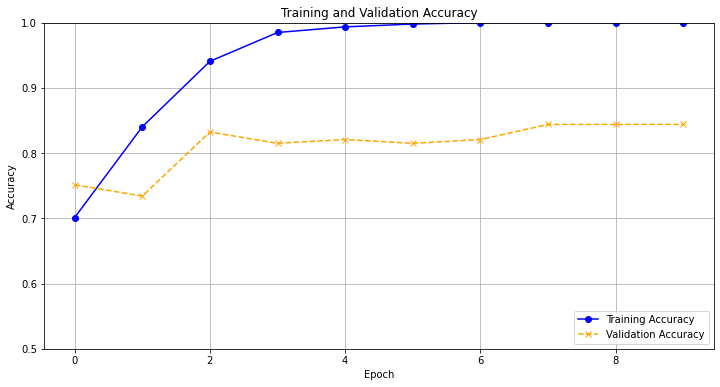

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], color='blue', linestyle='-', marker='o', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], color='orange', linestyle='--', marker='x', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## Plotting Training~Validation accuracy

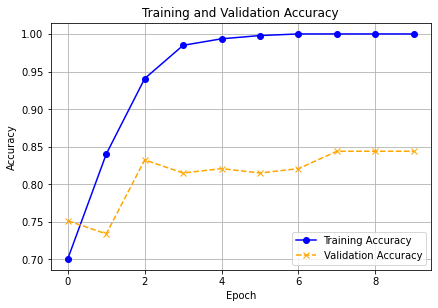

In [30]:
epochs_range = range(len(history.history['accuracy']))

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(epochs_range, history.history['accuracy'], color='blue', linestyle='-', marker='o', label='Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], color='orange', linestyle='--', marker='x', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')
plt.grid(True)


## Plotting Training~Validation loss

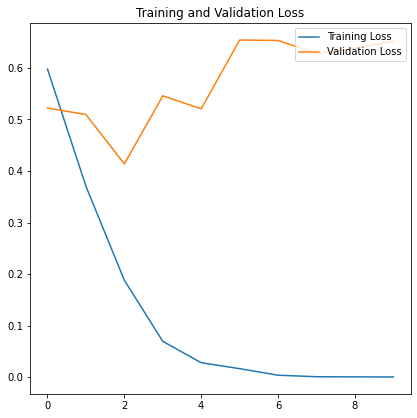

In [33]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Plotting Loss~Epoches

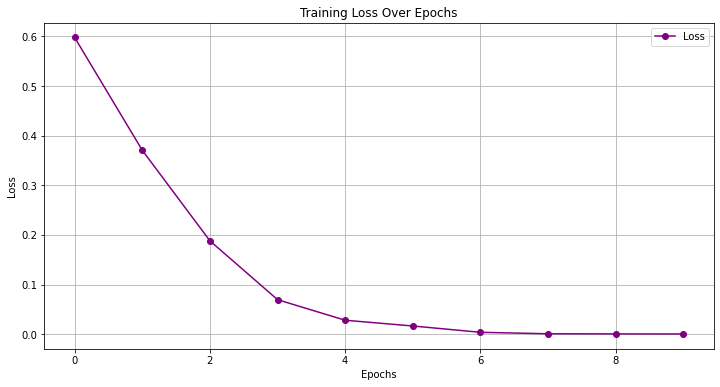

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(epochs_range, history.history['loss'], color='purple', linestyle='-', marker='o', label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()